# Climbing Down Mountains with MyGrad

In [1]:
import mygrad as mg
import noggin as nog

%matplotlib notebook
# you may need to run this cell twice for the matplotlib notebook magic to work

In this notebook we will be using mygrad's auto-differentiation functionality to perform gradient descent in various scenarios.

This notebook will also introduce you to [noggin](https://noggin.readthedocs.io/en/latest/), which will permit us to conveniently record and plot our data in real-time! 


### Write a gradient-descent function
Write a gradient descent function that takes in a tensor (`param`) and a *learning rate* ($\delta$). 

This function assumes that you already have created some computational graph, and that you have already used back-propagation to compute the relevant derivatives of the terminal node in the computational graph with respect to the tensor quantities that it depends on. 

That is, `param.grad` stores the derivatives that you want to use to update `param` itself via gradient-descent.

For the tensor, update its *underlying numpy array* according to the gradient descent. Use the augmented-update operator `-=` to update the array in-place (Why is this desirable? Chat with a neighbor). Because you are modifying the data of these tensors in-place, this function need not return anything.

In [2]:
def grad_descent(param, learning_rate):
    """ Update tensors according to vanilla gradient descent.
    
    Parameters
    ----------
    param : mygrad.Tensor
        The tensor to be updated using gradient-descent
    
    learning_rate : float
        The learning rate
    
    Returns
    -------
    None
        The parameter should be updated in-place"""
    # <COGINST>        
    if param.grad is not None:
        param.data -= learning_rate * param.grad
    # </COGINST>

Based on our discussion of derivatives, test your function. Define the computational graph for $f(x) = 2x + 1$, evaluated at $x=10$. Use `mygrad` to compute $\frac{df}{dx}\Bigr\rvert_{x = 10.0}$ (which, of course, will be stored in `x.grad`)

Pick a learning rate, and perform *one* gradient-descent step to update $x$. Before running the calculation write down what you expect the updated value of $x$ to be, and use this to test your algorithm.


<COGINST>As we saw in the earlier notebook, $\frac{df}{dx}\Bigr\rvert_{x = 10.0}$ is $2$. Thus our update should look like:

\begin{align}
x_\text{new} = x_\text{old} - \delta \frac{df}{dx}\Bigr\rvert_{x = 10.0} = 10. - \delta \times 2
\end{align}

Say we take $\delta=3$, then our updated $x$ will be 4.
</COGINST>

In [14]:
# <COGINST>
x = mg.Tensor(10.0)
f = 2 * x + 1
f.backward()
grad_descent(x, learning_rate=3.0)
print(x)
# </COGINST>

Tensor(4.)


## Descending $f(x) = x^2$

<IPython.core.display.Javascript object>


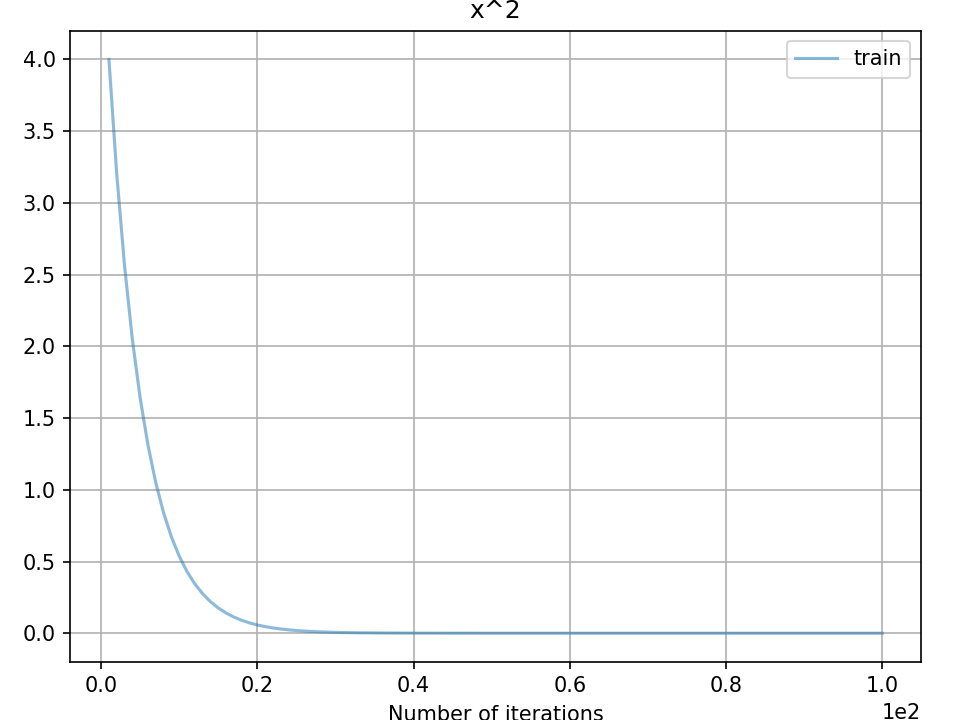

In [19]:
# run this cell
# `plotter` is an object produced by noggin; it can be used to 
# record and plot our value of `x` as we update it

# read the docstring for `create_plot`. What does `max_fraction_spent_plotting` do?
plotter, fig, ax = nog.create_plot("x^2", max_fraction_spent_plotting=1.)

We are going to use gradient-descent to find the minimum value of $f(x) = x^2$ (which we should find to be $x=0$).

Let's pick a starting value of $x=5.$ and a learning-rate of $\delta=0.1$. We will need to compute derivatives with respect to $x$, so $x$ will need to be a mygrad-tensor. Define these values here:

In [20]:
plotter.max_fraction_spent_plotting = .7  # you can reduce this value to speed-up plotting

In [21]:
# <COGINST>
lr = 0.1
x = mg.Tensor(5.)
# </COGINST>


Now, we will make successive gradient-based steps (gradient and derivative mean the same thing here) to move $x$ towards the minimum. Define `num_updates` to store the number of  successive steps that we want to take. Start with $100$.

In [22]:
# Define `num_steps`
# Once you run this cell, take a look at the plot we set up previously (above)
# You can run this cell multiple times to see the gradient-descent
# continue to plot evolve

# <COGINST>
num_steps = 100
# </COGINST>

for cnt in range(num_steps):
    # Evaluate f for the current value of x (i.e. perform a "forward-pass")
    f = x ** 2 # <COGLINE>

    # Use mygrad to compute df/dx
    f.backward() # <COGLINE>

    # Update `x` using gradient descent so that `f` will be smaller
    grad_descent(x, lr) # <COGLINE>

    # this will log our current value of `x` with noggin and plot it
    plotter.set_train_batch({"x^2": x.item()}, batch_size=1)

# This ensures that we have plotted our most up-to-date data
plotter.plot()

Did we take enough steps to minimize $f$? Adjust `num_steps` and, if you'd like, the learning rate, and resume the descent until you near the actual minimum.


## Descending Multiple Independent Functions


Before, we were able to find the minimum of $f(x)=x^2$. But what if we wanted to minimize multiple functions simultaneously? Thankfully `mygrad` has the machinery that will allow us to do so! Let's say we want to minimize the functions $f(x)=x$, $g(x)=x^2$, and $h(x)=x^3$. To do so, we can simply create a tensor that tracks the values of each of the three functions as we perform gradient descent. So, we can define a tensor that stores the values of $x$, then apply our functions to yield a tensor storing $\begin{bmatrix}x & x^2 & x^3\end{bmatrix}$.

Instantiate a tensor below, where the starting value for each function is $x=7.$ (a float)

In [23]:
# <COGINST>
x = mg.Tensor([7., 7., 7.])
# </COGINST>

Now let's set up a `noggin` plot that will allow us to track the values of each function as we update with gradient descent.

<IPython.core.display.Javascript object>


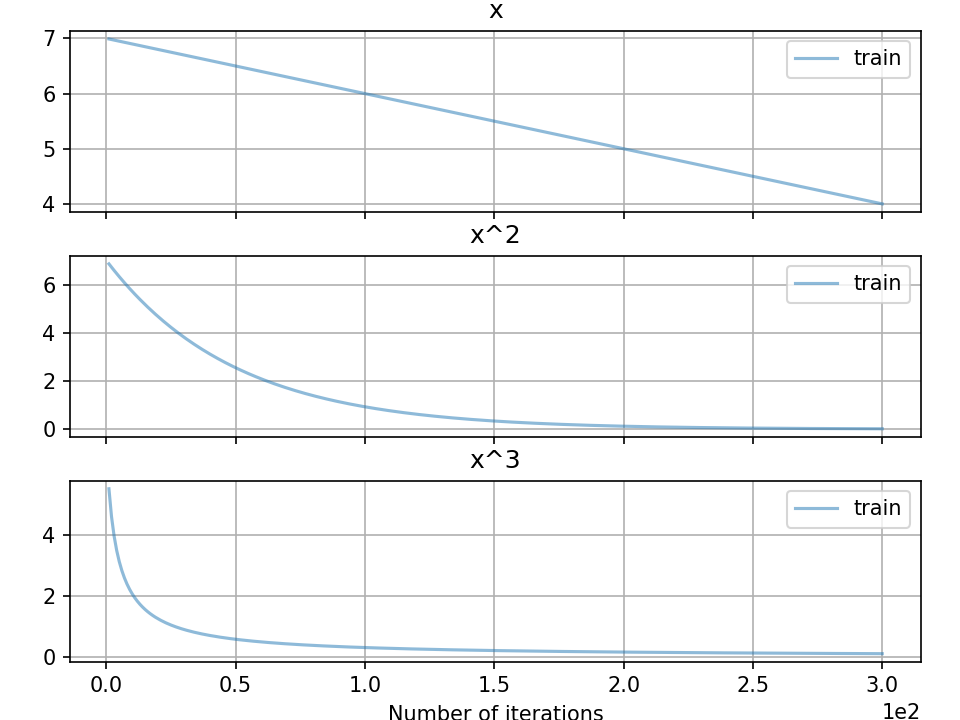

In [24]:
# run this cell

# read the docstring for `create_plot` to see the different valid data types for our plotting metrics
plotter, fig, ax = nog.create_plot(["x", "x^2", "x^3"], max_fraction_spent_plotting=1.)

Now how can we actually minimize our functions? Well, if we apply each of our functions to the elements in our tensor, when we call `backward`, the `grad` attribute will store the corresponding derivative for each function. Thus, after the first call of `backward`, `grad` will be of the form: 

\begin{equation}
\begin{bmatrix}\frac{d(x)}{dx}\Bigr|_{x=10} & \frac{d(x^2)}{dx}\Bigr|_{x=10} & \frac{d(x^3)}{dx}\Bigr|_{x=10}\end{bmatrix}
\end{equation}

Just as before, we will make repeated gradient descent steps to try to minimize our functions. But now, instead of our simply calling our function as `f = x ** 2`, we need to raise each element to a different power. Given that `mygrad` mirrors numpy's vectorization, is there a quick way we can do this (that doesn't require us to manually raise each element to a power)? 

For hyper-parameters, try using `num_steps` of $300$ and `lr` of $0.01$.

In [25]:
# define `num_steps` and `lr`
# <COGINST>
import numpy as np
lr = 0.01
num_steps = 300
# </COGINST>

for cnt in range(num_steps):
    # Evaluate f for the current value of x (i.e. perform a "forward-pass")
    f = x ** np.array([1, 2, 3]) # <COGLINE>
    
    # Use mygrad to compute df/dx
    f.backward() # <COGLINE>
    
    # Update `x` using gradient descent so that `f` will be smaller
    grad_descent(x, lr) # <COGLINE>
    
    # this will log our current value of `x` for each of our functions and plot it
    plotter.set_train_batch({"x": x[0].item(), 
                             "x^2": x[1].item(),
                             "x^3": x[2].item()}, batch_size=1)

# This ensures that we have plotted our most up-to-date data
plotter.plot()

What do you see in the plots? Is this what we should expect? Discuss with a neighbor.

Please note that we intentionally dedicated a lot of computational resources to updating the plots in real time. These 300 steps of gradient-descent can be performed extremely quickly if we update the plot less frequently.

If we wanted to, we could minimize functions other than $x$, $x^2$, and $x^3$. Take a look at the [math functions](https://mygrad.readthedocs.io/en/latest/math.html) offered by `mygrad`.


## Descending a Multivariate Function


Up to now, we've only tried minimizing functions of one variable, i.e. of the form $f(x)$. But when we start training models with gradient descent, we'll need to minimize functions of hundreds or thousands of variables. How do we do this? Let's start with a simple example: $f(x,y)=x^2+y^2$. This can be visualized as:

![multi](pics/multivar_func.png)


Clearly there is a minimum at $x=y=0$. But how can gradient descent find this minimum for us? All we have to do is track the values for $x$ and $y$ in tensors, and once we call `f.backward()`, the appropriate gradients will accumulate within the `grad` attributes of the tensors. Below, define `x` and `y` tensors, with starting values of $x=3.7$ and $y=6.3$. Use a single tensor of the form $\begin{bmatrix}x & y\end{bmatrix}$.

In [26]:
v = mg.Tensor([3.7, 6.3]) # <COGLINE>

Now let's create our `noggin` plot, which will track the values of both $x$ and $y$ as we perform our gradient descent steps. What should the plot for $x$ look like? For $y$?

<IPython.core.display.Javascript object>


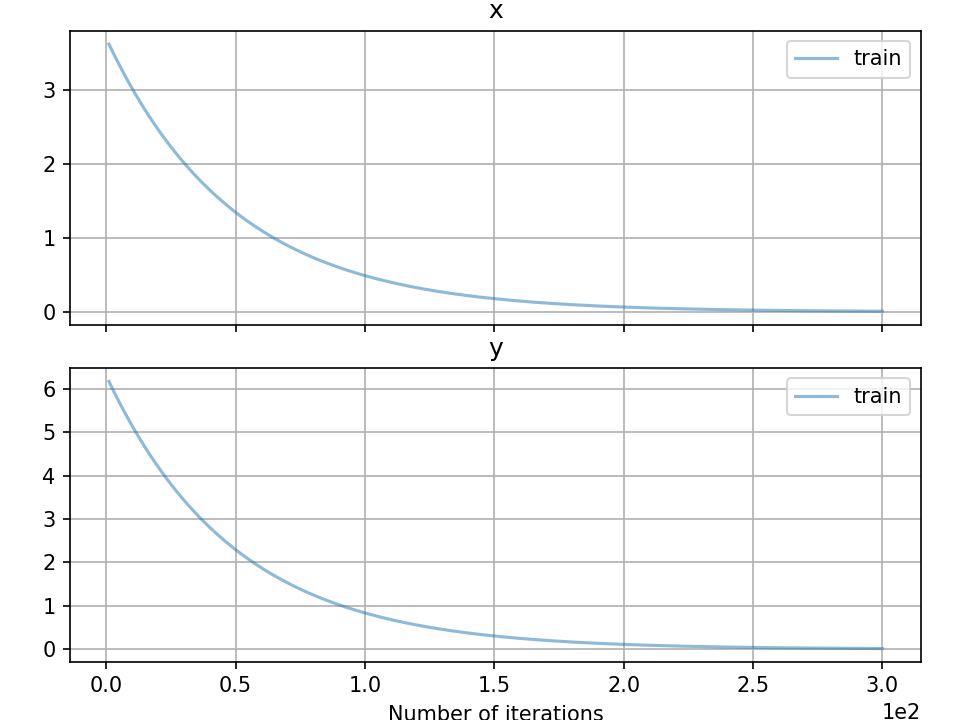

In [27]:
# run this cell

# what will the `x` and `y` plots look like?
plotter, fig, ax = nog.create_plot(["x", "y"], max_fraction_spent_plotting=1.)

Just as before, perform the gradient descent updates to minimize our two variables. You can again use `num_steps` of $300$ and `lr` of $0.01$.

In [28]:
# define `num_steps` and `lr`
# <COGINST>
lr = 1E-2
num_steps = 300
# </COGINST>

for cnt in range(num_steps):
    # Evaluate f for the current value of x (i.e. perform a "forward-pass")
    f = (v**2).sum() # <COGLINE>
    
    # Use mygrad to compute df/dx
    f.backward() # <COGLINE>
    
    # Update both `x` and `y` using gradient descent so that `f` will be smaller
    grad_descent(v, lr) # <COGLINE>
    
    # this will log our current value of `x` for each of our functions and plot it
    plotter.set_train_batch({"x": v[0].item(), 
                             "y": v[1].item()}, batch_size=1)

# This ensures that we have plotted our most up-to-date data
plotter.plot()

Try messing around with different functions of $x$ and $y$ or changing the learning rate hyperparameter. How does this change the behaviour of $x$ and $y$ as you perform gradient descent?